##Install Required Libraries

In [1]:
!pip install torch==2.3.1
!pip install --user trl==0.11.4
!pip install peft==0.14.0
!pip install matplotlib==3.9.0
!pip install pandas
!pip install numpy==1.26.0
!pip install --user datasets==3.2.0
!pip install transformers==4.45.2

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 480.6/480.6 kB 15.0 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 179.3/179.3 kB 14.5 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.23.0+cu126 requires torch==2.8.0, but you have torch 2.3.1 which is incompatible.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.9.0 which is incompatible.
torchaudio 2.8.0+cu126 requires torch==2.8.0, but you have torch 2.3.1 which is incompatible.
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î

##Import Libraries

In [2]:
import multiprocessing
import os
import requests
import tarfile
import pandas as pd
import matplotlib.pyplot as plt
import torch

from datasets import load_dataset
from peft import LoraConfig
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    GPT2Tokenizer,
    set_seed,
    GenerationConfig,
)
from trl import DPOConfig, DPOTrainer

##Load and Configure Model & Tokenizer

In [3]:
model = AutoModelForCausalLM.from_pretrained("gpt2")
model_ref = AutoModelForCausalLM.from_pretrained("gpt2")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"
model.config.use_cache = False

model

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

##Load and Preprocess Dataset

In [4]:
#Load dataset
ds = load_dataset("BarraHome/ultrafeedback_binarized")

#Reduce dataset size
for key in ds:
    cnt = 50
    ds[key] = ds[key].select(range(cnt))

#Process dataset
def process(row):
    del row["prompt_id"], row["messages"], row["score_chosen"], row["score_rejected"]
    row["chosen"] = row["chosen"][-1]["content"]
    row["rejected"] = row["rejected"][-1]["content"]
    return row

ds = ds.map(process, num_proc=multiprocessing.cpu_count(), load_from_cache_file=False)

train_dataset = ds['train_prefs']
eval_dataset = ds['test_prefs']

train_dataset[0]

README.md: 0.00B [00:00, ?B/s]

data/train_prefs-00000-of-00001.parquet:   0%|          | 0.00/226M [00:00<?, ?B/s]

data/test_prefs-00000-of-00001.parquet:   0%|          | 0.00/7.29M [00:00<?, ?B/s]

data/test_sft-00000-of-00001.parquet:   0%|          | 0.00/3.72M [00:00<?, ?B/s]

data/train_gen-00000-of-00001.parquet:   0%|          | 0.00/184M [00:00<?, ?B/s]

data/test_gen-00000-of-00001.parquet:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

Generating train_prefs split:   0%|          | 0/61135 [00:00<?, ? examples/s]

Generating train_sft split:   0%|          | 0/61135 [00:00<?, ? examples/s]

Generating test_prefs split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test_sft split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating train_gen split:   0%|          | 0/61135 [00:00<?, ? examples/s]

Generating test_gen split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/50 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/50 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/50 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/50 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/50 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/50 [00:00<?, ? examples/s]

{'prompt': 'how can i develop a habit of drawing daily',
 'chosen': "Developing a daily habit of drawing can be challenging but with consistent practice and a few tips, it can become an enjoyable and rewarding part of your daily routine. Here are some strategies to help you develop the habit of drawing daily:\n\n1. Set a specific time: Allocate a specific time of the day to draw. It could be in the morning, afternoon, or evening. Make drawing a part of your daily routine.\n2. Set a specific duration: Determine the amount of time you want to spend on drawing each day. It can be as little as 10 minutes or as long as an hour. Be consistent with the duration to help build the habit.\n3. Start small and simple: Don't try to create a masterpiece every day, start with simple and easy-to-do sketches. Focus on improving your skills gradually.\n4. Use a variety of tools and mediums: Experiment with different tools like pencils, pens, markers, and different mediums like paper, canvas, or digital 

##LoRA Configuration

In [5]:
peft_config = LoraConfig(
    r=4,
    target_modules=['c_proj', 'c_attn'],
    task_type="CAUSAL_LM",
    lora_alpha=8,
    lora_dropout=0.1,
    bias="none",
)

##DPO Configuration

In [6]:
training_args = DPOConfig(
    beta=0.1,
    output_dir="dpo",
    num_train_epochs=5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    remove_unused_columns=False,
    logging_steps=10,
    gradient_accumulation_steps=1,
    learning_rate=1e-4,
    evaluation_strategy="epoch",
    warmup_steps=2,
    fp16=False,
    save_steps=500,
    report_to='none'
)

/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of ü§ó Transformers. Use `eval_strategy` instead
  warnings.warn(


##DPO Trainer Initialization

In [7]:
trainer = DPOTrainer(
    model=model,
    ref_model=None,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    peft_config=peft_config,
    max_length=512,
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in DPOTrainer, please use the DPOConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/layer.py:1264: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/root/.local/lib/python3.12/site-packages/trl/trainer/dpo_trainer.py:655: UserWarning: You passed `max_length` to the DPOTrainer, the value you passed will override the one in the `DPOConfig`.
  warnings.warn(
/root/.local/lib/python3.12/site-packages/trl/trainer/dpo_trainer.py:673: UserWarning: `max_prompt_length` is not set in the DPOConfig's init it will default to `128` by default, but you should do it yourself in the future.
  warnings.warn(


Tokenizing train dataset:   0%|          | 0/50 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1154 > 1024). Running this sequence through the model will result in indexing errors


Tokenizing eval dataset:   0%|          | 0/50 [00:00<?, ? examples/s]

##Model Training

In [8]:
trainer.train()

Could not estimate the number of tokens of the input, floating-point operations will not be computed


TrainOutput(global_step=250, training_loss=0.48773095321655274, metrics={'train_runtime': 108.3986, 'train_samples_per_second': 2.306, 'train_steps_per_second': 2.306, 'total_flos': 0.0, 'train_loss': 0.48773095321655274, 'epoch': 5.0})

##Plot Training vs Evaluation Loss

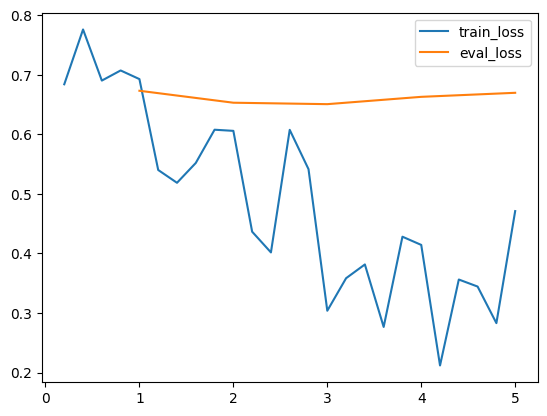

In [9]:
log = pd.DataFrame(trainer.state.log_history)
log_t = log[log['loss'].notna()]
log_e = log[log['eval_loss'].notna()]

plt.plot(log_t["epoch"], log_t["loss"], label="train_loss")
plt.plot(log_e["epoch"], log_e["eval_loss"], label="eval_loss")
plt.legend()
plt.show()

##Load Trained or Pre-Trained DPO Model

In [10]:
#Try loading trained model
try:
    dpo_model = AutoModelForCausalLM.from_pretrained('./dpo/checkpoint-250')
except:
    #If unavailable, load pre-trained checkpoint
    url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/YIDeT3qihEpWChdXN_RmTg/DPO-tar.gz'
    filename = './DPO.tar'

    response = requests.get(url)
    with open(filename, 'wb') as f:
        f.write(response.content)

    if tarfile.is_tarfile(filename):
        with tarfile.open(filename, 'r') as tar:
            tar.extractall()
            print("Files extracted:", tar.getnames())
    dpo_model = AutoModelForCausalLM.from_pretrained('./DPO')

##Generate and Compare Responses

In [11]:
set_seed(42)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

generation_config = GenerationConfig(
    do_sample=True,
    top_k=1,
    temperature=0.1,
    max_new_tokens=25,
    pad_token_id=tokenizer.eos_token_id
)

PROMPT = "Is a higher octane gasoline better for your car?"
inputs = tokenizer(PROMPT, return_tensors='pt')

#DPO model response
outputs_dpo = dpo_model.generate(**inputs, generation_config=generation_config)
print("DPO response:\t", tokenizer.decode(outputs_dpo[0], skip_special_tokens=True))

#GPT-2 baseline response
gpt2_model = AutoModelForCausalLM.from_pretrained('gpt2')
outputs_gpt2 = gpt2_model.generate(**inputs, generation_config=generation_config)
print("\nGPT2 response:\t", tokenizer.decode(outputs_gpt2[0], skip_special_tokens=True))


DPO response:	 Is a higher octane gasoline better for your car?

The answer is yes. The higher octane gasoline is better for your car.

The higher octane gasoline

GPT2 response:	 Is a higher octane gasoline better for your car?

The answer is yes. The higher octane gasoline is more efficient and more fuel efficient.

The higher oct
